# DoorDash ML Exercise- Predicting Delivery Time
DoorDash is very dependent on how accurate some of it's internal app data is- predictions of delivery time is very impactful on user experience and revenue spend. For this exercise, we will explore the interaction between order and customer information and the time it takes for an order to be delivered. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. Order lateness / underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it. Orders that are very early / late are also much worse than those that are only slightly early / late. 



In [303]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math as ma
import scipy.stats as st
import warnings
import pickle
warnings.filterwarnings('ignore')


from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor,BaggingRegressor


from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno

In [304]:
#import data
train= pd.read_csv('historical_data.csv')
test = pd.read_csv('predict_data.csv')
#train=train.head(1000)
#test=test.head(1000)

In [305]:
print("Train has "+str(train.shape[0])+" observations and "+str(train.shape[1])+" variables")
print("Test has "+str(test.shape[0])+" observations and "+str(test.shape[1])+" variables")

Train has 197428 observations and 9 variables
Test has 54778 observations and 9 variables


In [306]:
train.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [307]:
test.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


In [308]:
print('Train Min Time is ' +str(min(train['created_at']))+ ' and the max train time is ' +str(max(train['created_at'])))

Train Min Time is 2014-10-19 05:24:15 and the max train time is 2015-02-18 06:00:44


There is only one observation from 2014 in train- let's drop that one

In [309]:
print(train[pd.to_datetime(train.created_at).dt.year<2015].shape[0])
train=train[pd.to_datetime(train.created_at).dt.year==2015]
print('Train Min Time is ' +str(min(train['created_at']))+ ' and the max train time is ' +str(max(train['created_at'])))

1
Train Min Time is 2015-01-21 15:22:03 and the max train time is 2015-02-18 06:00:44


In [310]:
print('Test Min Time is ' +str(min(test['created_at']))+ ' and the max test time is ' +str(max(test['created_at'])))

Test Min Time is 2015-02-18 14:50:28 and the max test time is 2015-02-25 05:59:49


## Data Summary- How many missing values?
I will look at the number of missing values and also how the relate to each other. Can we say they are missing at random and impute them?

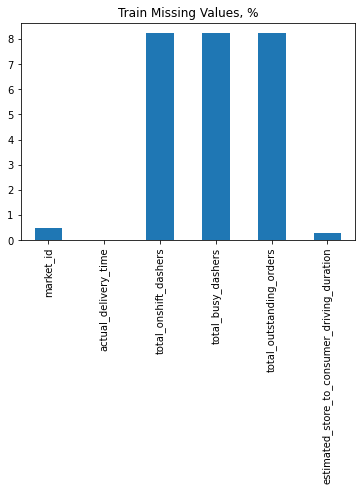

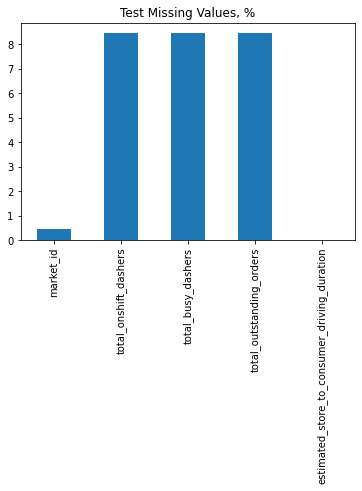

In [311]:
#find percentage of missing values for each column
missing_train = train.isnull().mean()*100
#only look at with missing values because so many columns
missing_train = missing_train[missing_train > 0]
missing_train.plot.bar(title='Train Missing Values, %')
plt.show()


#find percentage of missing values for each column
missing_test = test.isnull().mean()*100
#only look at with missing values because so many columns
missing_test = missing_test[missing_test > 0]
missing_test.plot.bar(title='Test Missing Values, %')
plt.show()



Looks like the propotion is very similar for test and train datasets. As we see below, it looks like the missingness is random- in the matrix graph, missing values are pretty randomized and in the heatmap(only showing missing values), the only high correlations are the ones that are all NA at the same time- this is likely due to the fact that when one piece of order info is missing, all three elements are. Therefore, we can conclude the data is missing at random. This enables us to impute values with multivariate imputation, seen below.

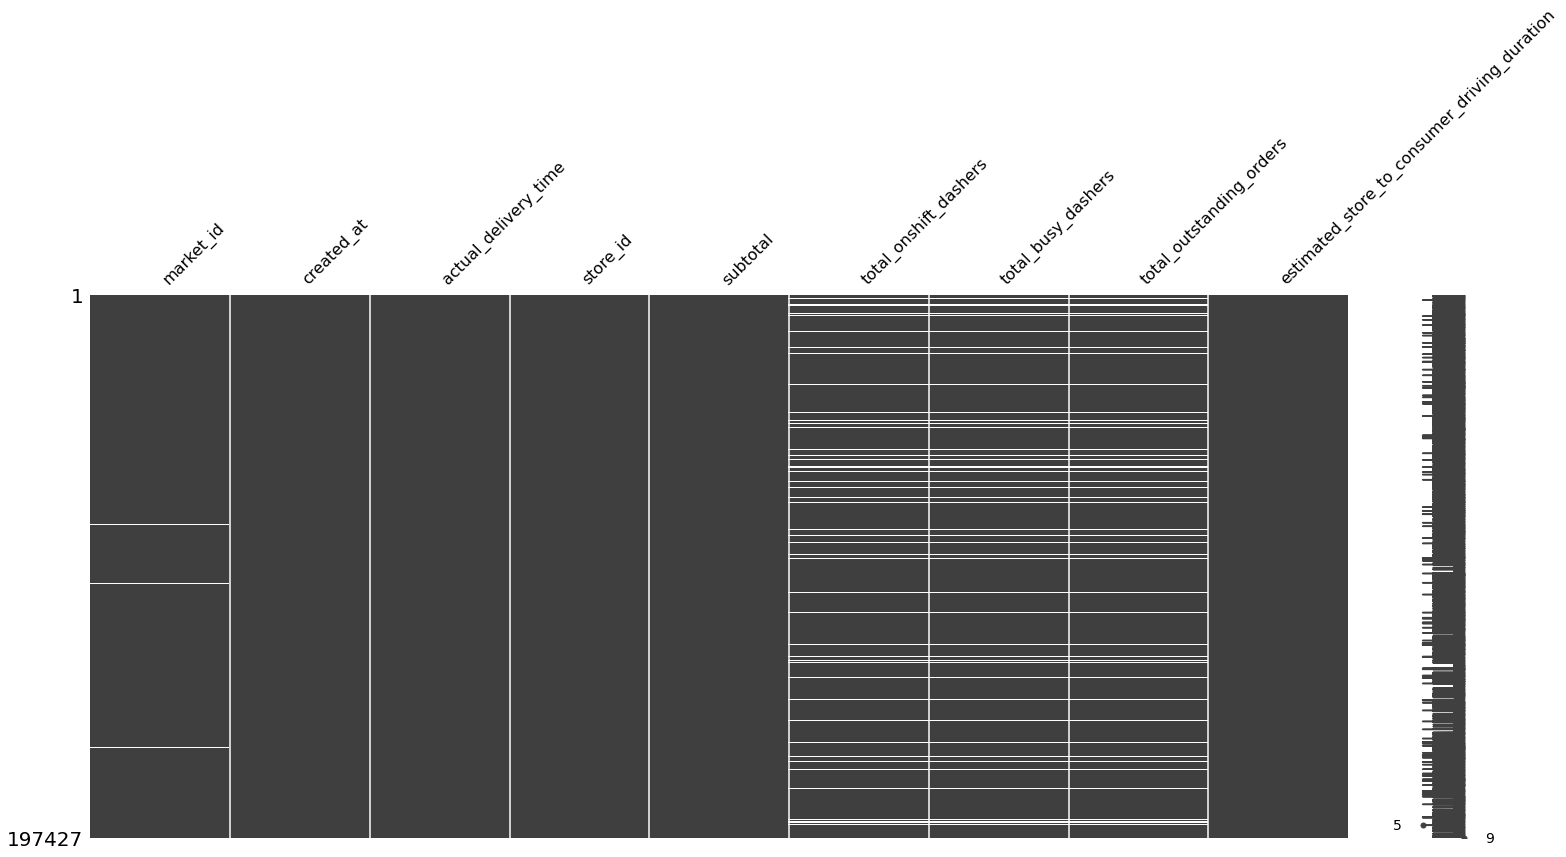

In [312]:
msno.matrix(train);

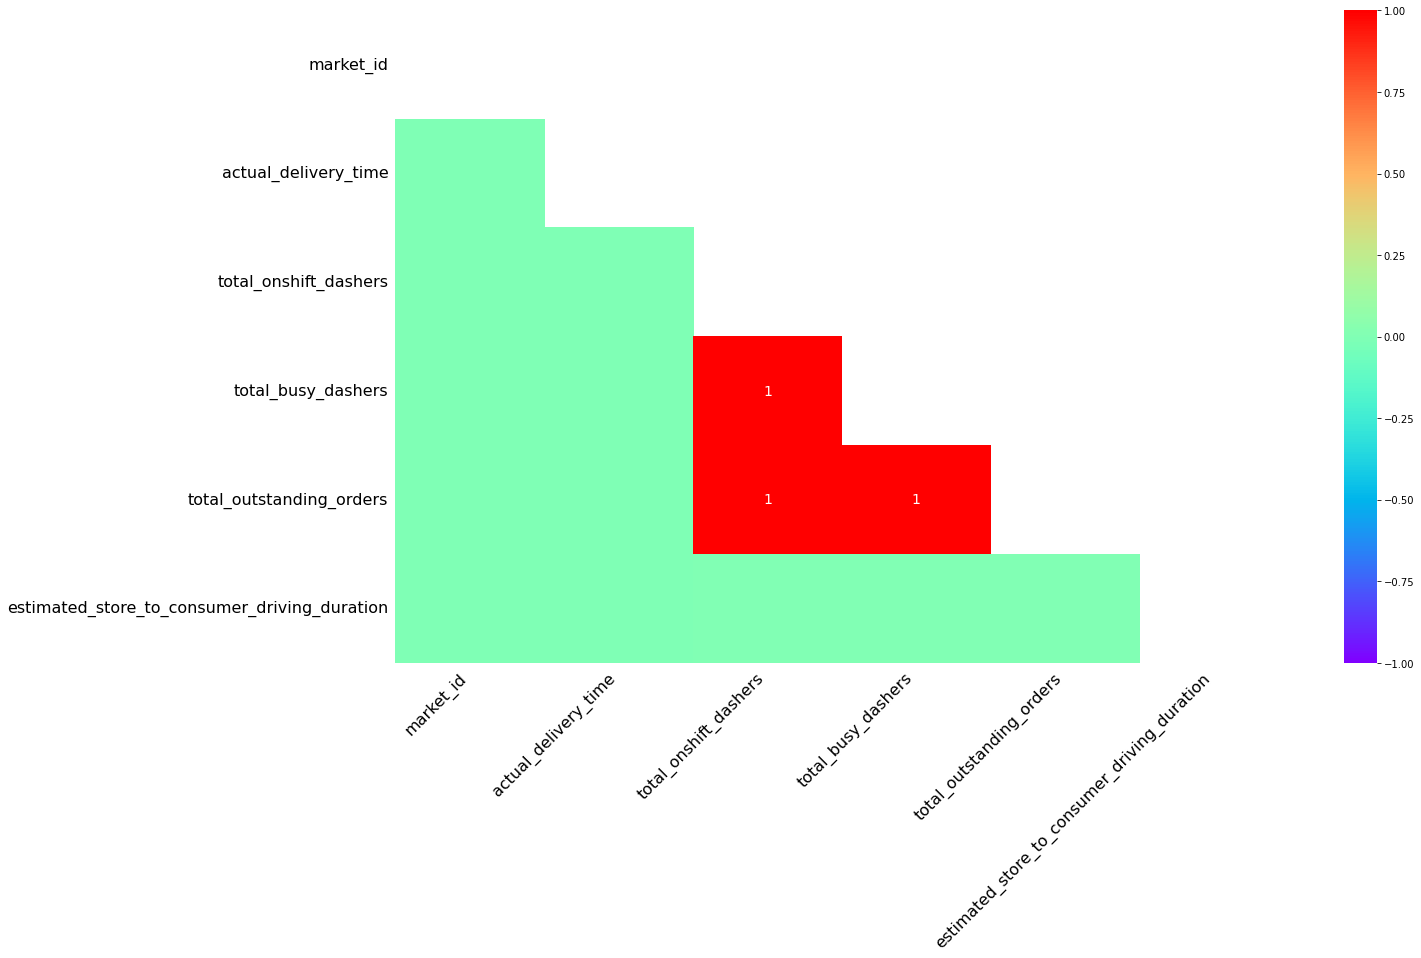

In [313]:
msno.heatmap(train, cmap='rainbow');

### There are some missing values for market_id- let's match them up with store and see if a consensus will improve the missing count
We will combine them by majority votes grouped by store id

In [314]:
combinedDF=train[['market_id','store_id']].append(test[['market_id','store_id']])
#for every store, let's match them with the most often labeled location for consistency
uniquestores=[*combinedDF['store_id'].unique()]

for s in uniquestores:
    v=combinedDF[combinedDF.store_id==s].market_id.value_counts()
    #update to most common location for that store
    commonlocation=[*v.values]
    if len(commonlocation)>0:
        combinedDF.loc[combinedDF.store_id==s, 'market_id'] = [*v.index][0]
    else:
        combinedDF.loc[combinedDF.store_id==s, 'market_id'] = None
combinedDF=combinedDF.drop_duplicates()

## Preprocessing and Variable Creation

In [315]:
#denote popular store by one that has had more than 100 visits in training period
store_ids=[*train['store_id'].value_counts()[train['store_id'].value_counts()>100].index]

def preprocess(df,combinedDF):
    '''
    Input: 
    df- dataframe, either train or test
    combinedDF- dataframe with market_id to merge. This will fill in many missing values in this variable
    
    Output: processed dataframe
    
    
    Preprocess data and create some variables. Specificially:
    - creation time changed to date time attribute
    - observations dropped from train if no target available
    - Target was created(actual delivery time in seconds)
    - a few date attributes were created( day of week, month, hour)
    - popular store was created, which indicates if >100 orders made per store
    - market id was corrected to be the most common value across a store in dataset- i.e. if 100 store_id=1 said market_id=2
    and 10 said market_id=6, also those store_id would be coerced to market_id=2


    
    '''
    #also we can convert some columns to date time and create a few more date attributes

    # Change daytime column to daytime object
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    #don't do this for test data
    if 'actual_delivery_time' in [*df.columns]:
        #we can drop NA from actual_delivery_time, because we can assume these delieveries didn't happen
        df=df.dropna(subset=['actual_delivery_time'])


        df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
        df['Target'] = df['actual_delivery_time'] - df['created_at']
        #we want this time in seconds
        df['Target'] = df['Target'].dt.total_seconds()
        
        
    #now we can create some variables for the creation time- note we won't do this for delivered time since this won't be in the test set
    #add day of week and hour for created_at
    weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

    df['day_of_week'] =df['created_at'].dt.dayofweek#day_name()
    df['weekend'] =0

    df['weekend'] =df.loc[df.day_of_week>=4, 'weekend'] = 1

    df['month'] = df['created_at'].dt.month
    df['hour'] = df['created_at'].dt.hour

    df['Popular_Store']=0
    df.loc[df.store_id.isin(store_ids), 'Popular_Store'] = 1
    
    #join with dataframe with correct location based on store id
    
    df=df.drop(columns=['market_id'])
    df=df.merge(combinedDF,how='left',on='store_id')
    
    #also make is so that on shift dashers is always greater than or equal to busy dashers
    #df['total_onshift_dashers']=df[["total_busy_dashers", "total_onshift_dashers"]].max(axis=1)
    
    return(df)
        
train=preprocess(train,combinedDF).reset_index(drop=True)
test=preprocess(test,combinedDF).reset_index(drop=True)


In [316]:
#by combining the store id and market id, we greatly reduce the market_id NAs
train.isnull().sum()

created_at                                          0
actual_delivery_time                                0
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_store_to_consumer_driving_duration      526
Target                                              0
day_of_week                                         0
weekend                                             0
month                                               0
hour                                                0
Popular_Store                                       0
market_id                                           2
dtype: int64

## Multivariate Imputation

- we will assume our data is missing at random
    - for this, we can use iterative imputation
    - a feature with nans is used as the target variable and all others are treated as features
    - using the trained regressor, we can predict any missing values
    - I will not use any variables not available in the testing set, i.e. the time to delivery
    


In [299]:
#remove some columns that don't exist in the other df- created_at is redundant with our created features
def prepare_for_imputation(df):
    '''
    Input: 
    df- dataframe, either train or test
    
    Output: dataframe with dropped columns
    
    
    Prepare data for multivariate imputation- this will involve dropping columns from each set, depending on if they are available.
    '''
    
    train_impute=df.copy()
    if 'actual_delivery_time' in [*train_impute.columns]:
        droppedcols=['created_at','actual_delivery_time','Target']
    else:
        droppedcols=['created_at', 'delivery_id']


    train_impute=train_impute.drop(columns=droppedcols)
    return train_impute

train_impute=prepare_for_imputation(train)
test_impute=prepare_for_imputation(test)

### Imputation
- Using random forests, we can impute any missing values
- fit on training set
- apply same transformation to test set so we keep imputation style consistent

In [300]:
#we will use random forest regressor for imputation
imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=10), random_state=0)
df_train_imp = imputer.fit_transform(train_impute)
df_train_imp = pd.DataFrame(data=df_train_imp, columns = train_impute.columns).reset_index()

df_test_imp=imputer.transform(test_impute)
df_test_imp = pd.DataFrame(data=df_test_imp, columns = test_impute.columns)

Now we need to add back some columns using the original dataframe that we dropped for imputation. Most importantly, delivery time. 

In [301]:
def add_back_cols(dforig,df):
    '''
    Input: 
    dforig- original dataframe, prior to imputation
    df- imputed dataframe, either train or test
    
    Output: 
    dataframe with columns added back in 
    
    This function adds back columns to each imputed dataframe after they were dropped for that purpose.
    Also done:
    -Month and Day of week were changed from numeric to the actual phrase.
    -Market ID is coerced to the closest value(only necessary for two data points)
    -Flag was created in case dasher info had to be imputed
    
    '''
    if 'actual_delivery_time' in [*dforig.columns]:
        droppedcols=['created_at','actual_delivery_time','Target']
    else:
        droppedcols=['created_at', 'delivery_id']
    for col in droppedcols:
        df[col]=dforig[col]

    
    df['month'] =df['created_at'].dt.month_name()


    df['day_of_week'] =df['created_at'].dt.day_name()
    #df=pd.get_dummies(df, prefix=['weekday','month'])

    #round any imputations of market_id to nearest integer- 
    #there can't be any in between numbers and if it's closest, then 
    #we will assume this is close enough to be the integer to be 
    #considered that market- this happens in relatively few instances,
    #so it is not worth exploring other possibilities right now
    df['market_id']=df['market_id'].round(0)
    
    df['dasher_info_missing'] = np.where(dforig.total_busy_dashers.isnull(), 0, 1)

    return df

train=add_back_cols(train,df_train_imp)
test=add_back_cols(test,df_test_imp)

Now we can see we successfully imputed all NAs and removed cases where delivery time was not available

In [302]:
print(train.isnull().mean()*100)
print('--------------------------------------------------------')
print(test.isnull().mean()*100)



index                                           0.0
store_id                                        0.0
subtotal                                        0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_store_to_consumer_driving_duration    0.0
day_of_week                                     0.0
weekend                                         0.0
month                                           0.0
hour                                            0.0
Popular_Store                                   0.0
market_id                                       0.0
created_at                                      0.0
actual_delivery_time                            0.0
Target                                          0.0
dasher_info_missing                             0.0
dtype: float64
--------------------------------------------------------
store_id                                    

# Visualizations
We need to look at the data to see if there is any predictive power in the feature set. Specifically, is there any correlation between the target variable and the predictors?

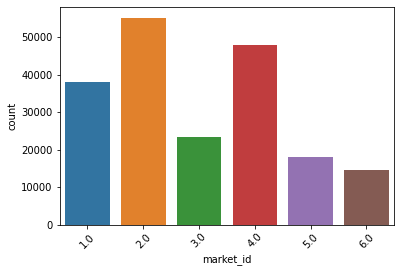

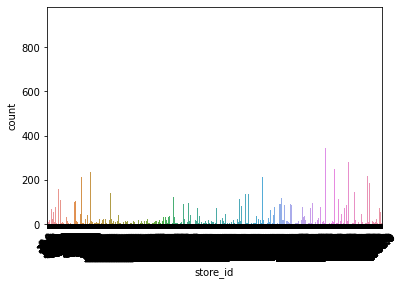

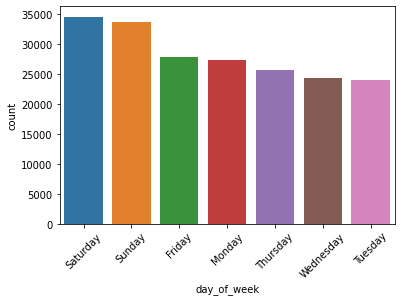

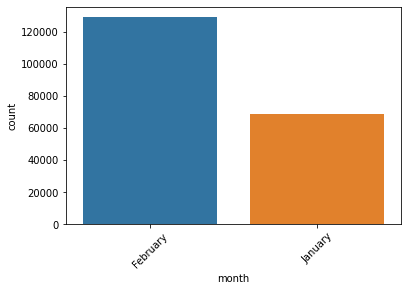

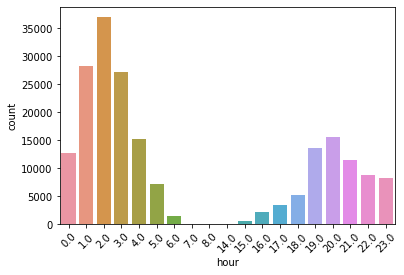

In [98]:
columns = ['market_id','store_id','day_of_week','month','hour']
for i,col in enumerate(columns):
    tmp = train[col].value_counts().to_frame().reset_index()
    tmp.columns = [col,"count"]
    plt.figure(i)
    sns.barplot(tmp[col],tmp["count"])
    plt.xticks(rotation=45)

Based on the above, we can make the following observations:
- market 2 and 4 are ordered from the most. 
- There are tons of restaurants ordered from, but certainly ones that get ~200 orders in training period
- Saturday and Sunday are the most popular days
- February where the majority of our data is located.
- Early morning hours are most times to order

In [99]:
train.describe()

,index,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,weekend,hour,Popular_Store,market_id,Target,dasher_info_missing
count,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.0,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000
mean,98709.500000,3530.581248,2682.331380,44.603929,41.479882,57.390045,545.324804,1.0,8.467379,0.427829,2.980043,2865.131294,0.917632
std,56990.389409,2053.498629,1823.109519,33.195308,31.056250,50.732115,219.118188,0.0,8.658799,0.494765,1.524280,1613.285907,0.274925
min,0.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,1.0,0.000000,0.000000,1.000000,101.000000,0.000000
25%,49354.750000,1686.000000,1400.000000,18.000000,16.000000,19.000000,383.000000,1.0,2.000000,0.000000,2.000000,2104.000000,1.000000
50%,98709.500000,3592.000000,2200.000000,38.200000,35.000000,43.000000,544.000000,1.0,3.000000,0.000000,3.000000,2660.000000,1.000000
75%,148064.250000,5299.000000,3395.000000,62.000000,60.000000,80.900000,702.000000,1.0,19.000000,1.000000,4.000000,3381.000000,1.000000
max,197419.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,1.0,23.000000,1.000000,6.000000,373879.000000,1.000000


Based on above, let's fix some of the columns- less than 0 shouldn't be allowed
Also there are some really long and short order times. However, there are enough that we don't want to remove them. This could highly bias the test set since there are plenty of them. However, there are two observations that are extreme outliers in delivery time. We will drop these.  

In [102]:
def fix_vars(df):
    '''
    Input: 
    df- dataframe, either train or test
    
    Output: dataframe with some variable alterations
    
    This function will make sure some variables are not negative. 
    Namely, total_onshift_dashers, total_busy_dashers, total_outstanding_orders.
    There are all the variables that had observations less than 0    
    '''
    
    
    cols=['total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
    for j in cols:
        df[j].values[df[j] <0] = 0
    return df

train=fix_vars(train)
test=fix_vars(test)

There are quite a few outliers for the Target variable. We will focus on those >3 hours for delivery time and after that it gets a little more common. Only drop the most extreme outliers- this accounts for less than .1% of the population.

In [192]:
#there are a few orders with huge delivery times
print(sum((train['Target']/3600)>2))

#some orders take less than 10 minutes to deliver
sum((train['Target']/60)<10)

#there are a couple more than 3 hours- we will drop these because this seem implausable, after that it gets more common
print(sum(train['Target']>10800))

#lets remore those 24 outleirs more than 3 hours
train=train[train['Target']<21600]

1089
137


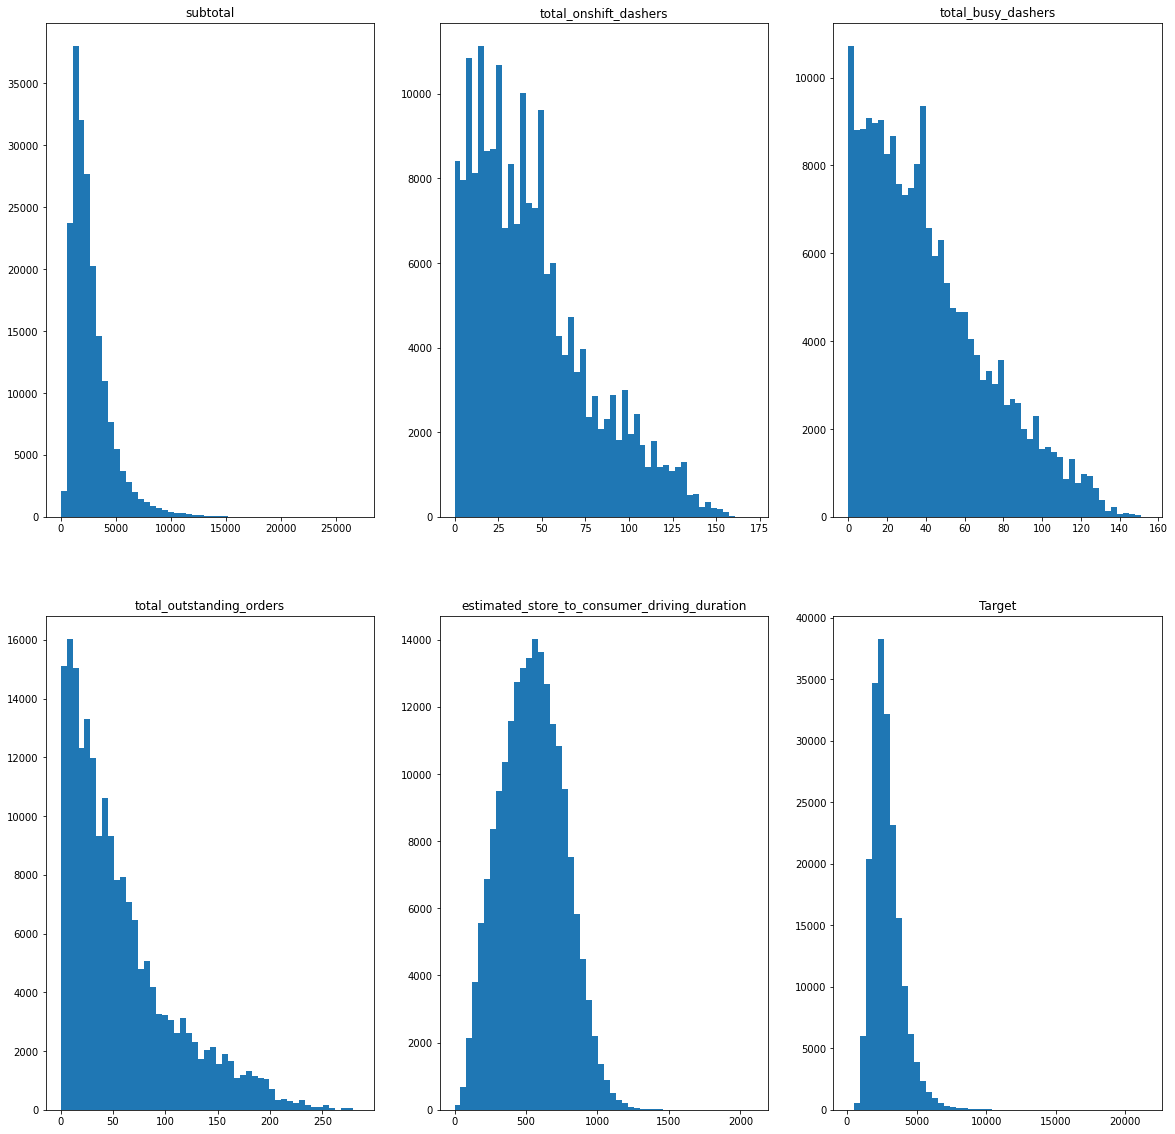

In [161]:
#check Numerical variables distribution
Numerical_column = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration','Target']
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

q=1

for j in Numerical_column:
    plt.subplot(2,3,q)
    plt.hist((train[j]), bins = 50)
    plt.title(j)
    q+=1


From above, there is a decent disribution of the target variable, mostly centered on <5000s. We can see that the estimated driving duration only makes up for a small portion of this, so a good chunk of data is missing, such as metrics of how long each store might take to prepare food. All the other variables are fairly right skewed. 

### Time Series- Let's look at total counts by date

(array([735647., 735648., 735649., 735650., 735651., 735652., 735653.,
        735654.]),
 <a list of 8 Text major ticklabel objects>)

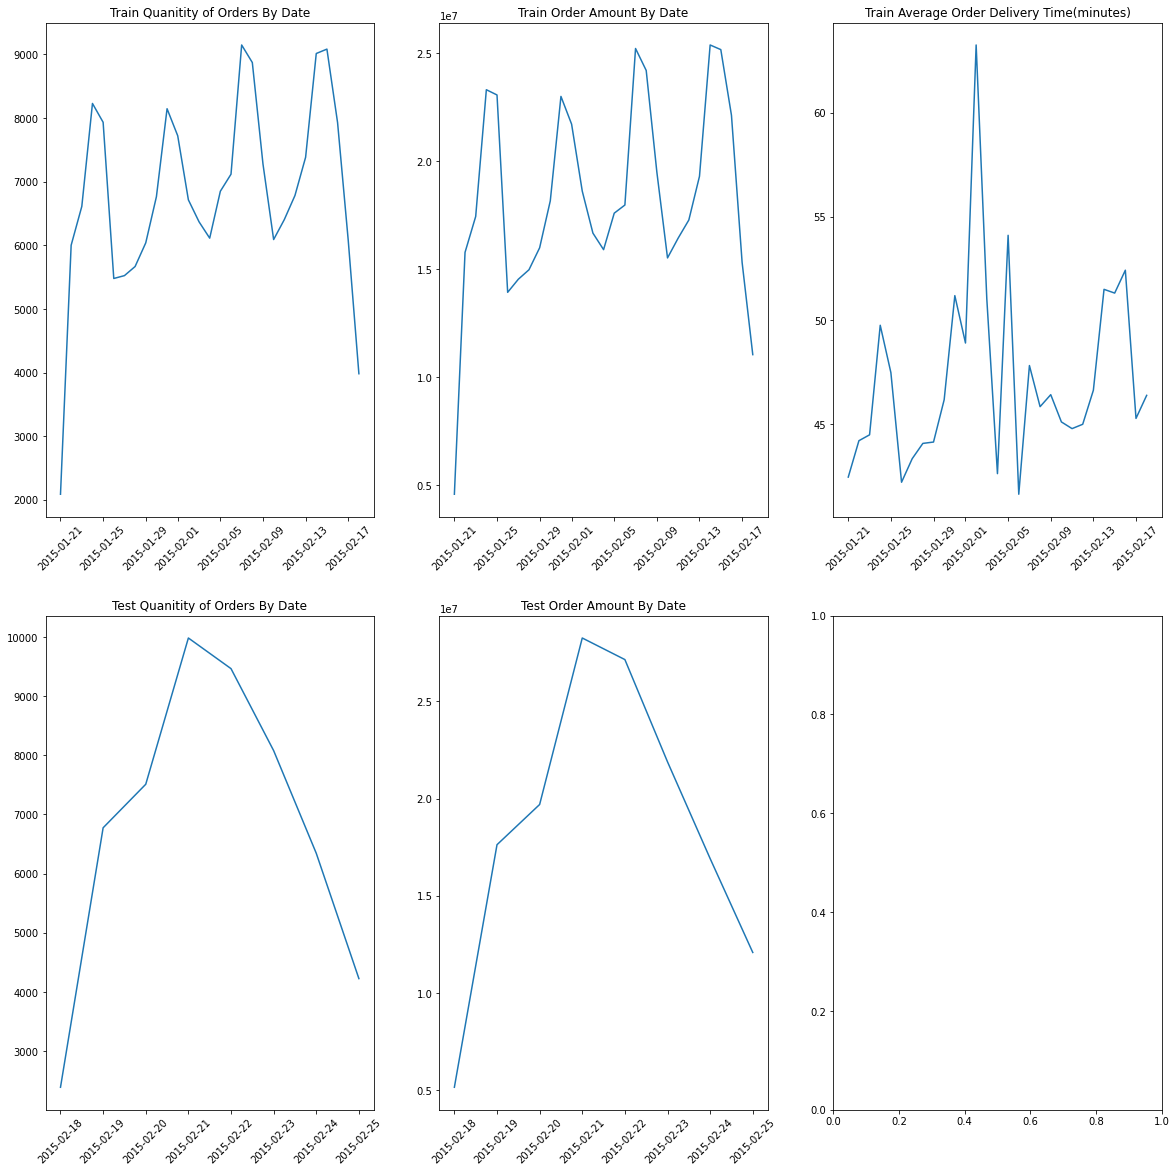

In [162]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
df = train.groupby([train['created_at'].dt.date]).agg({'subtotal':'count'}).reset_index()

plt.subplot(2,3,1)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Train Quanitity of Orders By Date')
plt.xticks(rotation=45)

df = train.groupby([train['created_at'].dt.date]).agg({'subtotal':'sum'}).reset_index()

plt.subplot(2,3,2)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Train Order Amount By Date')
plt.xticks(rotation=45)


df = train.groupby([train['created_at'].dt.date]).agg({'Target':'mean'}).reset_index()

plt.subplot(2,3,3)
plt.plot(df['created_at'], df['Target']/60)

plt.title('Train Average Order Delivery Time(minutes)')
plt.xticks(rotation=45)




df = train.groupby([test['created_at'].dt.date]).agg({'subtotal':'count'}).reset_index()

plt.subplot(2,3,4)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Test Quanitity of Orders By Date')
plt.xticks(rotation=45)


df = test.groupby([test['created_at'].dt.date]).agg({'subtotal':'sum'}).reset_index()

plt.subplot(2,3,5)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Test Order Amount By Date')
plt.xticks(rotation=45)

There is certainly a cyclical trend to quantity of orders and amount of orders by date, but the target variable doesn't follow the same trend. But, this may be influenced by extreme values as there is a large spike in the beginning of February. 

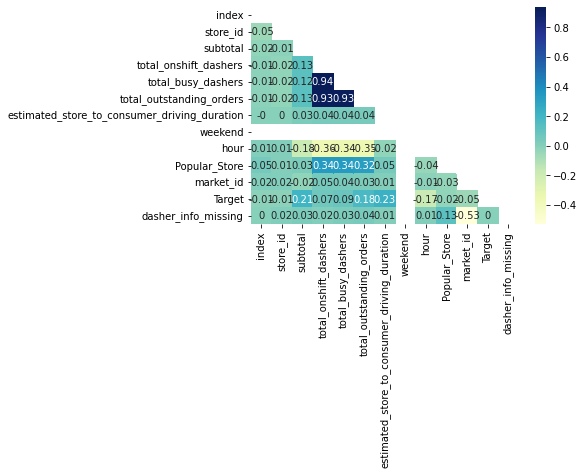

In [163]:
#correlation matrix
corrMatrix = train.corr().round(2)

# creating mask
mask = np.triu(np.ones_like(corrMatrix))
 
# plotting a triangle correlation heatmap
sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

Looking at the target variable, there are higher correlations for subtotal, total_outstanding_orders & estimated_store_to_consumer_driving_duration. This makes intuitive sense because higher order totals could make the order more attractive to drivers to pick up. The numer of outstanding orders is correlated to on shift dashers and therefore makes it more possible to be picked up. Finally, the estimated driving time gives us at least part of the answer to how long an order should take to be delivered.

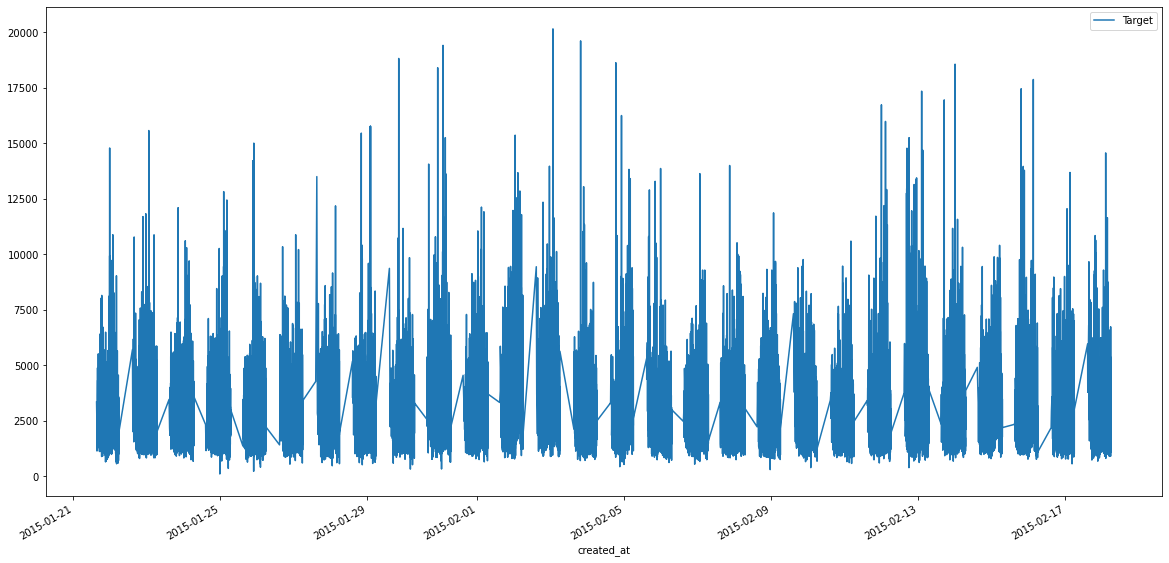

In [164]:
train.groupby([train["created_at"]]).mean()[['Target']].plot(legend=True, figsize=(20,10))

If we plot the target by time, there are relatively similar distributions by day-
no one day has all the large order times. In the hour plot below, there is a similar story. 2pm is a little elevated, but not extremely so. 

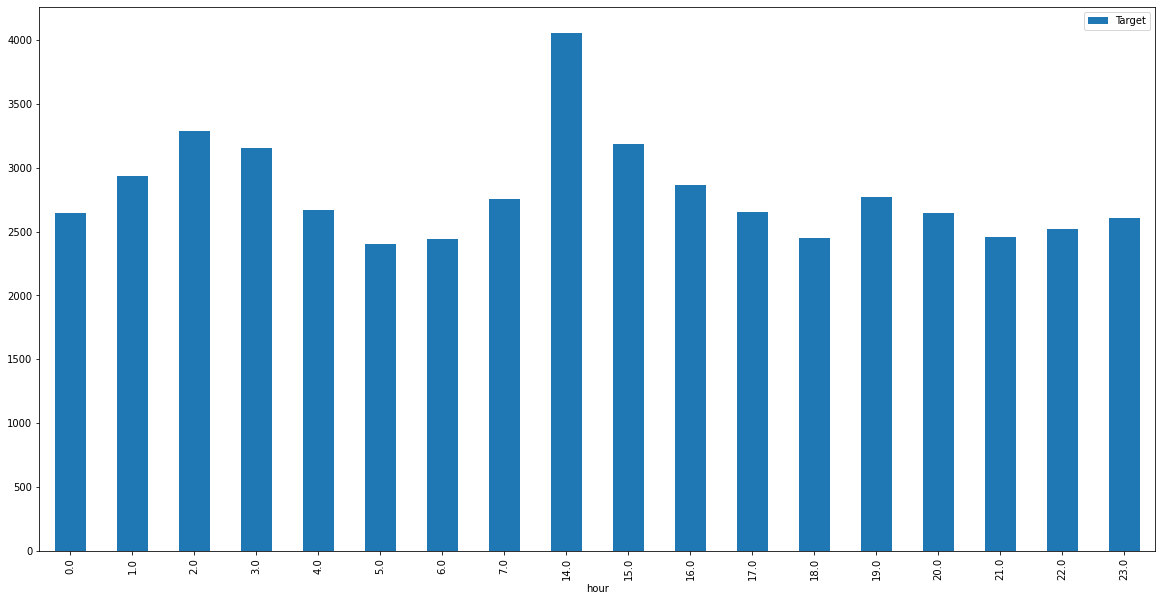

In [165]:
#look at hour and delivery time associated with it
train.groupby(["hour"]).mean()[['Target']].plot.bar(legend=True, figsize=(20,10))

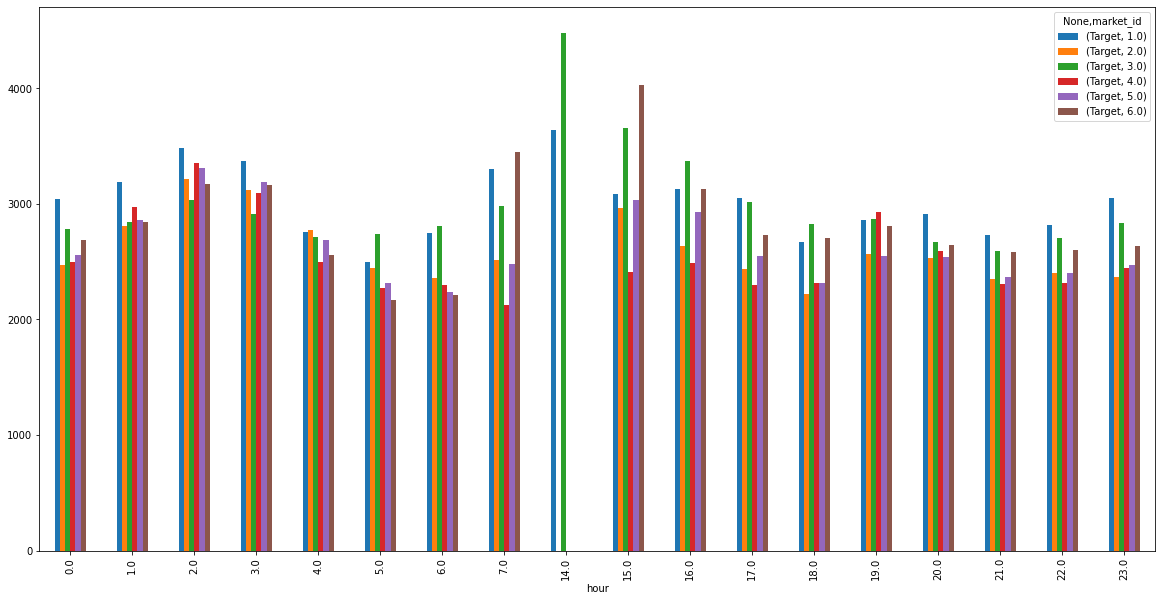

In [166]:
train.groupby(["hour",'market_id']).mean()[['Target']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

There is some variation if we look at order by market and hour, but this may be due to sample size and dynamics of each market(i.e. maybe late night is more prevalent with market 1). No one market dominates accross all time indicies so we won't do any more here.

Text(0, 0.5, 'Order Time (sec)')

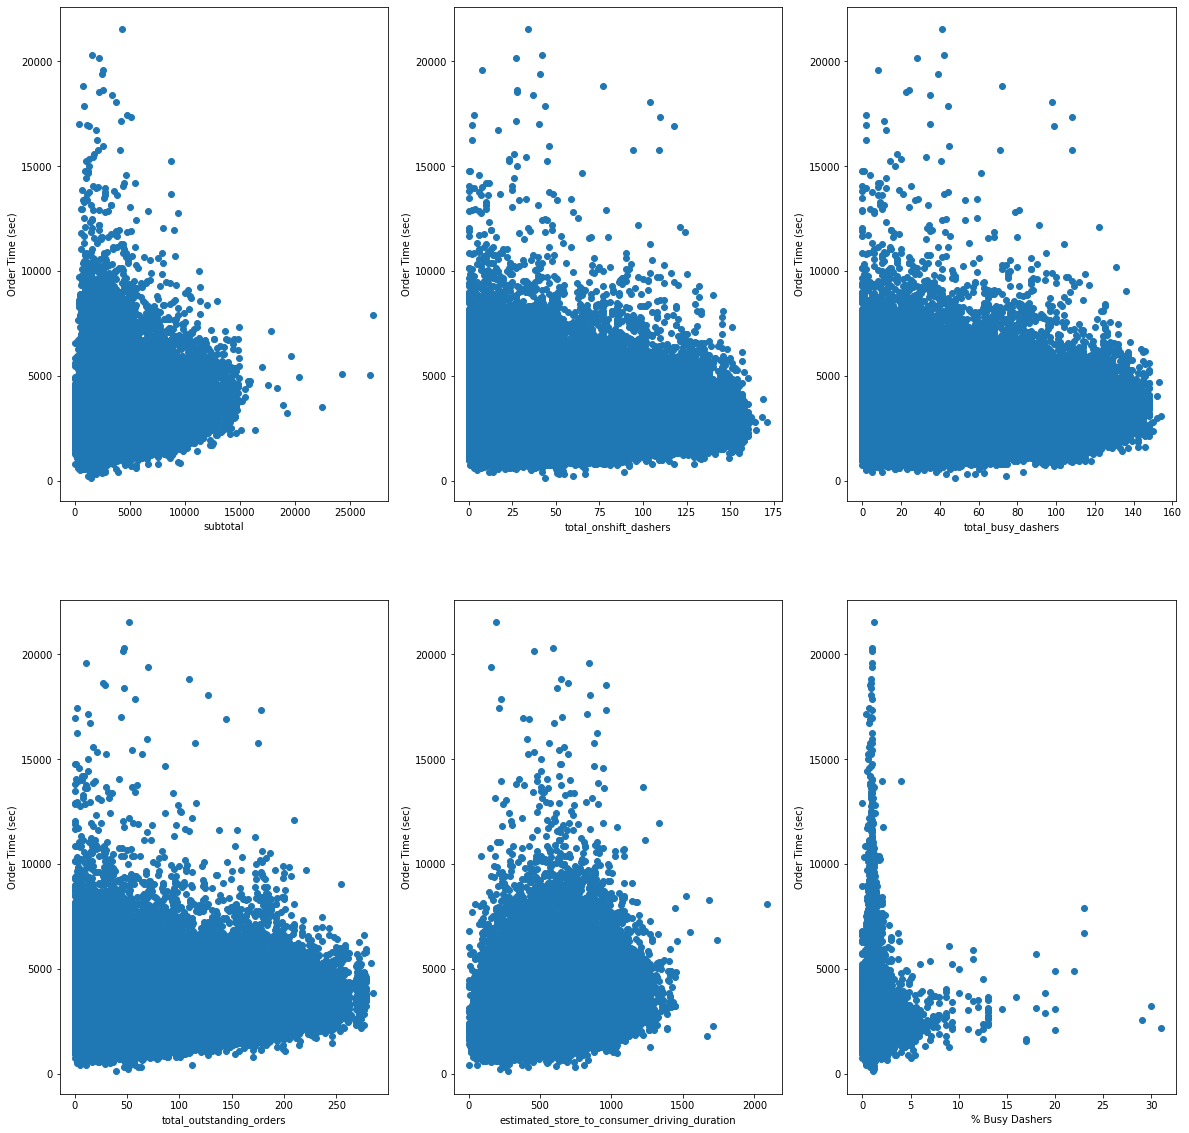

In [167]:
columns = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration']

fig, axes = plt.subplots(2, 3, figsize=(20, 20))
q=1
for col in (columns):
    plt.subplot(2,3,q)
    plt.scatter(train[col],train['Target'])
    #plt.plot(train[col],train['Target'])
    plt.xlabel(col)
    plt.ylabel('Order Time (sec)')
    q=q+1

plt.subplot(2,3,q)
plt.scatter(train['total_busy_dashers']/train['total_onshift_dashers'],train['Target'])
plt.xlabel('% Busy Dashers')
plt.ylabel('Order Time (sec)')


Of the above, the estimated driving duration seems to have the strongest correlation, as it increases as order time increases. The others have weaker associations, but I think that by combining them, we can derive more predictive power through a ML model.

### Let's Look at Some Transformations
- maybe Log transformation could be helpful(first 4 graphs)

We will not implement this, although it fixed normality because many of the algorithms we are considering(i.e. random forest) do not have a requirement for normality.

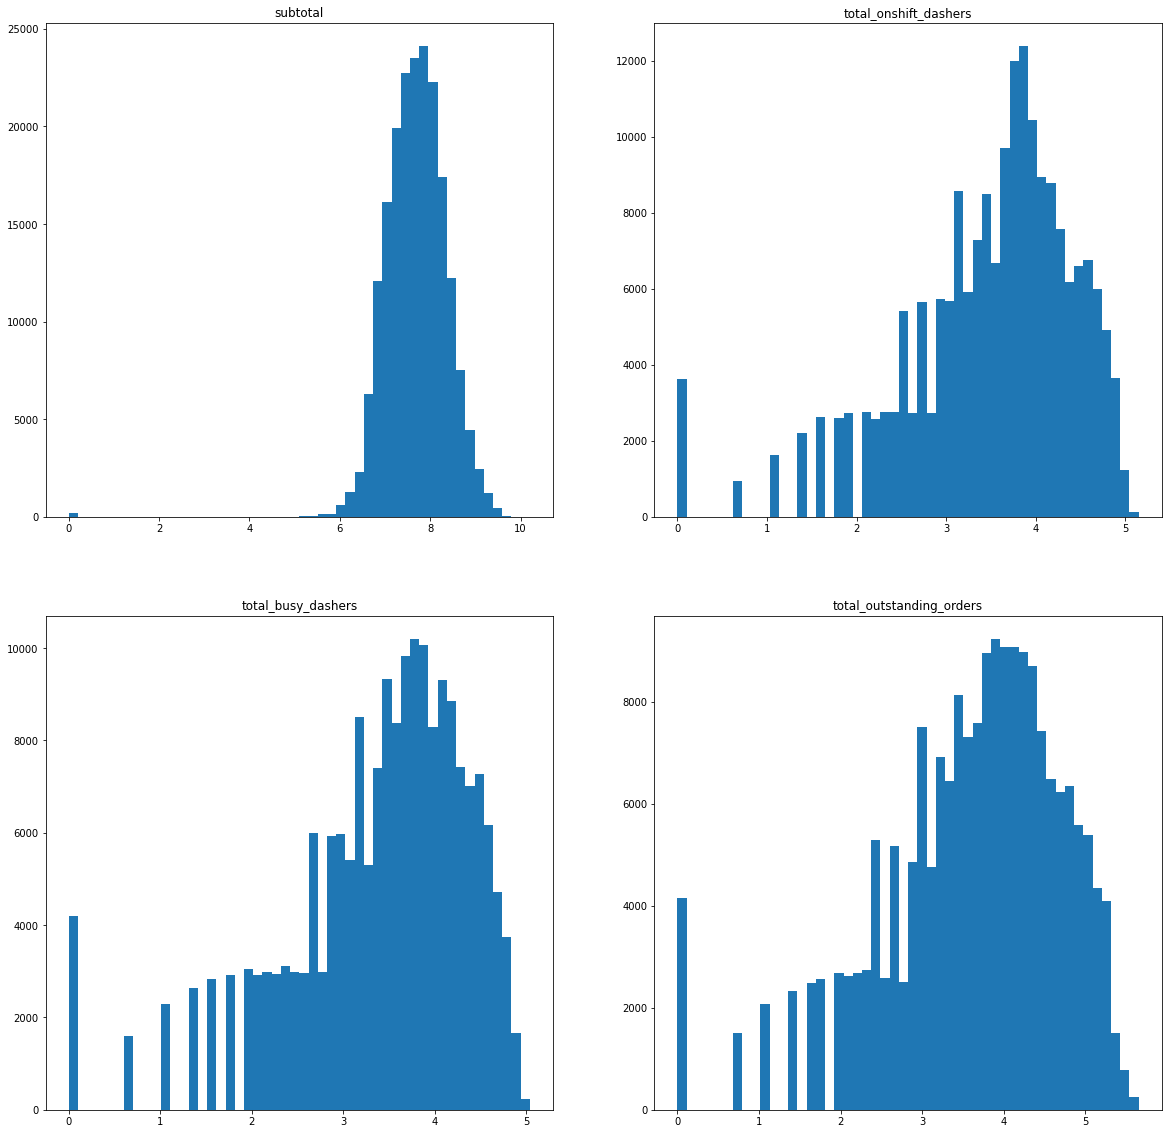

In [168]:
#check Numerical variables distribution
Numerical_column = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders']
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

q=1

for j in Numerical_column:
    plt.subplot(2,2,q)
    v=train[j]
    if q<=4:
        v=np.log1p(v)
    plt.hist(v, bins = 50)
    plt.title(j)
    q+=1

If we look at the number disribution of the Target variable over two hours, there are still quite a few instances, so we shouldn't simply drop all of them.

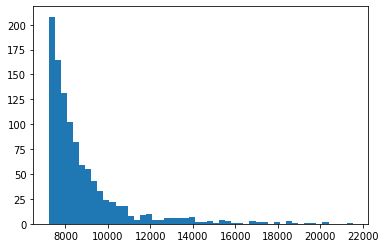

In [172]:
plt.hist(train.Target[train.Target>=(2*3600)],bins=50)
plt.show()

In [4]:
train.to_pickle('train.pickle')
test.to_pickle('test.pickle')

In [8]:
train=pd.read_pickle('train.pickle')
test=pd.read_pickle('test.pickle')

train.shape

(197396, 17)

## Final Transformations
We can create a few additional variables. These are driven by the fact that subtotal is an important variable, and that going off outstanding orders, maybe the order number history could prove to be a good predictor.
- sums for last 15 minutes and hour: order totals and orders received by market
- outstanding orders per dasher could be predictive in that it will tell us how many orders would need to be completed by dasher to finish all orders- analagous to how busy we are
- busy dashers- ratio of busy to all dashers currently

In [ ]:
from IPython.display import clear_output
from multiprocessing import Process

def order_metrics(df):
    '''
    Input: 
    df- dataframe, either train or test
    
    Output: dataframe with additional columns
    
    This function will add some columns based on past behavior:
    - number of orders made in same market in last 15,30,45, and 60 min
    - total of order subtotal made in same market in last 15,30,45, and 60 min
    - also create some ratios:
        dashers to orders ratios
        number of busy dashers
        number of dashers working
    '''

    #make sure target variable doesn't exist
    if 'Appended_DF' in locals():
        del Appended_DF

        
    
    t=df.copy()
    t=t[['created_at','market_id','subtotal']]
    #convert to datetime 
    t['created_at']=pd.to_datetime(t['created_at'])

    t['index_col']=t.index

    #need to make sure last index is also in iteration, otherwise will stop at last multiple of 100 in range
    ran=[*range(100, len(t), 100),len(t)]
    ran=[*set(ran)]
    ran=sorted(ran )
    print(ran)
    
    #need to do loop because it's too big to run all at once
    for j in ran:
        clear_output(wait=True)
        print(j)
        print(len(t))
        
        if j%100==0:
            firstindex=j-100
        else:
            firstindex=j-(j%100)
        
        t5=t.copy()
        t5=t5.iloc[firstindex:j,]
        
        #create time indicies at various points
        t5['minutesago60']=t5['created_at'] + pd.Timedelta(hours=-1)
        t5['minutesago15']=t5['created_at'] + pd.Timedelta(minutes=-15)
        t5['minutesago30']=t5['created_at'] + pd.Timedelta(minutes=-30)
        t5['minutesago45']=t5['created_at'] + pd.Timedelta(minutes=-45)


        #cross join
        x=pd.merge(t5,t,on=['market_id'],suffixes=['_original','_comparison'])
        x=x[(x['created_at_comparison']<=x['created_at_original'])&(x['created_at_comparison']>x['minutesago60'])&(x['index_col_original']!=x['index_col_comparison'])]

        x['subtotallast15']=0
        x['subtotallast30']=0
        x['subtotallast45']=0
        x['subtotallast60']=0
        
        #subtotal and orders numbers by time
        x['orderslast60']=(x['created_at_comparison']>x['minutesago60'])
        x['orderslast45']=(x['created_at_comparison']>x['minutesago45'])
        x['orderslast30']=(x['created_at_comparison']>x['minutesago30'])
        x['orderslast15']=(x['created_at_comparison']>x['minutesago15'])
        x.loc[x['orderslast15'],'subtotallast15']=x.subtotal_comparison
        x.loc[x['orderslast30'],'subtotallast30']=x.subtotal_comparison
        x.loc[x['orderslast45'],'subtotallast45']=x.subtotal_comparison
        x.loc[x['orderslast60'],'subtotallast60']=x.subtotal_comparison

        
        #create aggregate values by index
        v=x.groupby(['index_col_original'])["orderslast15","orderslast30","orderslast45","orderslast60",
                                            "subtotallast15", "subtotallast30","subtotallast45","subtotallast60"].apply(lambda x : x.astype(int).sum())

        if 'Appended_DF' in locals():
            Appended_DF.append(v)
        else:
            Appended_DF=v

    Appended_DF=Appended_DF.reset_index()

    df['index_col_original']=df.index
    
    #add back aggregated totals and make sure no NAs
    df=pd.merge(df,Appended_DF,on='index_col_original',how='left').fillna(0)

    df['dashers_working']=df['total_onshift_dashers']+df['total_busy_dashers']

    #create some ratios based on historical orders and dashers working
    df['dashers_orderratio']=df['total_outstanding_orders']/(df['total_onshift_dashers'])
    df['dashers_alldashers']=df['total_outstanding_orders']/(df['dashers_working'])
    df['busydashers']=df['total_busy_dashers']/(df['dashers_working'])
    df['availdashers_last15ordersratio']=df['orderslast15']/(df['total_onshift_dashers'])
    df['availdashers_last30ordersratio']=df['orderslast30']/(df['total_onshift_dashers'])
    df['availdashers_last45ordersratio']=df['orderslast45']/(df['total_onshift_dashers'])
    df['availdashers_lasthrordersratio']=df['orderslast60']/(df['total_onshift_dashers'])
    
    #if infinite, replace with nan
    df=df.replace(np.inf, np.nan)


    
    #fill in some missing values
    df['dashers_orderratio']=df['dashers_orderratio'].fillna(df['total_outstanding_orders'])
    df['dashers_alldashers']=df['dashers_alldashers'].fillna(df['total_outstanding_orders'])
    df['busydashers']=df['busydashers'].fillna(df['total_busy_dashers'])
    df['availdashers_last15ordersratio']=df['availdashers_last15ordersratio'].fillna(df['orderslast15'])
    df['availdashers_last30ordersratio']=df['availdashers_last30ordersratio'].fillna(df['orderslast30'])
    df['availdashers_last45ordersratio']=df['availdashers_last45ordersratio'].fillna(df['orderslast45'])
    df['availdashers_lasthrordersratio']=df['availdashers_lasthrordersratio'].fillna(df['orderslast60'])

    
    df.to_pickle('temp.pickle')
    

    return df

p1 = Process(target=order_metrics(train))
train=pd.read_pickle('temp.pickle')

p1 = Process(target=order_metrics(test))
test=pd.read_pickle('temp.pickle')

In [27]:
train.head()
train.isnull().sum()
train.head()

,index,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,day_of_week,weekend,month,...,subtotallast45,subtotallast60,dashers_working,dashers_orderratio,dashers_alldashers,busydashers,availdashers_last15ordersratio,availdashers_last30ordersratio,availdashers_last45ordersratio,availdashers_lasthrordersratio
0,0,1845.0,3441.0,33.0,14.0,21.0,861.0,Friday,1.0,February,...,102991.0,151883.0,47.0,0.636364,0.446809,0.297872,0.636364,0.969697,1.484848,2.151515
1,1,5477.0,1900.0,1.0,2.0,2.0,690.0,Tuesday,1.0,February,...,83240.0,110004.0,3.0,2.000000,0.666667,0.666667,11.000000,20.000000,29.000000,43.000000
2,2,5477.0,1900.0,1.0,0.0,0.0,690.0,Thursday,1.0,January,...,130736.0,181305.0,1.0,0.000000,0.000000,0.000000,24.000000,42.000000,58.000000,81.000000
3,3,5477.0,6900.0,1.0,1.0,2.0,289.0,Tuesday,1.0,February,...,62771.0,94926.0,2.0,2.000000,1.000000,0.500000,7.000000,25.000000,37.000000,55.000000
4,4,5477.0,3900.0,6.0,6.0,9.0,650.0,Sunday,1.0,February,...,470263.0,577799.0,12.0,1.500000,0.750000,0.500000,6.500000,15.166667,22.833333,28.500000


### Look at some of the engineered variables

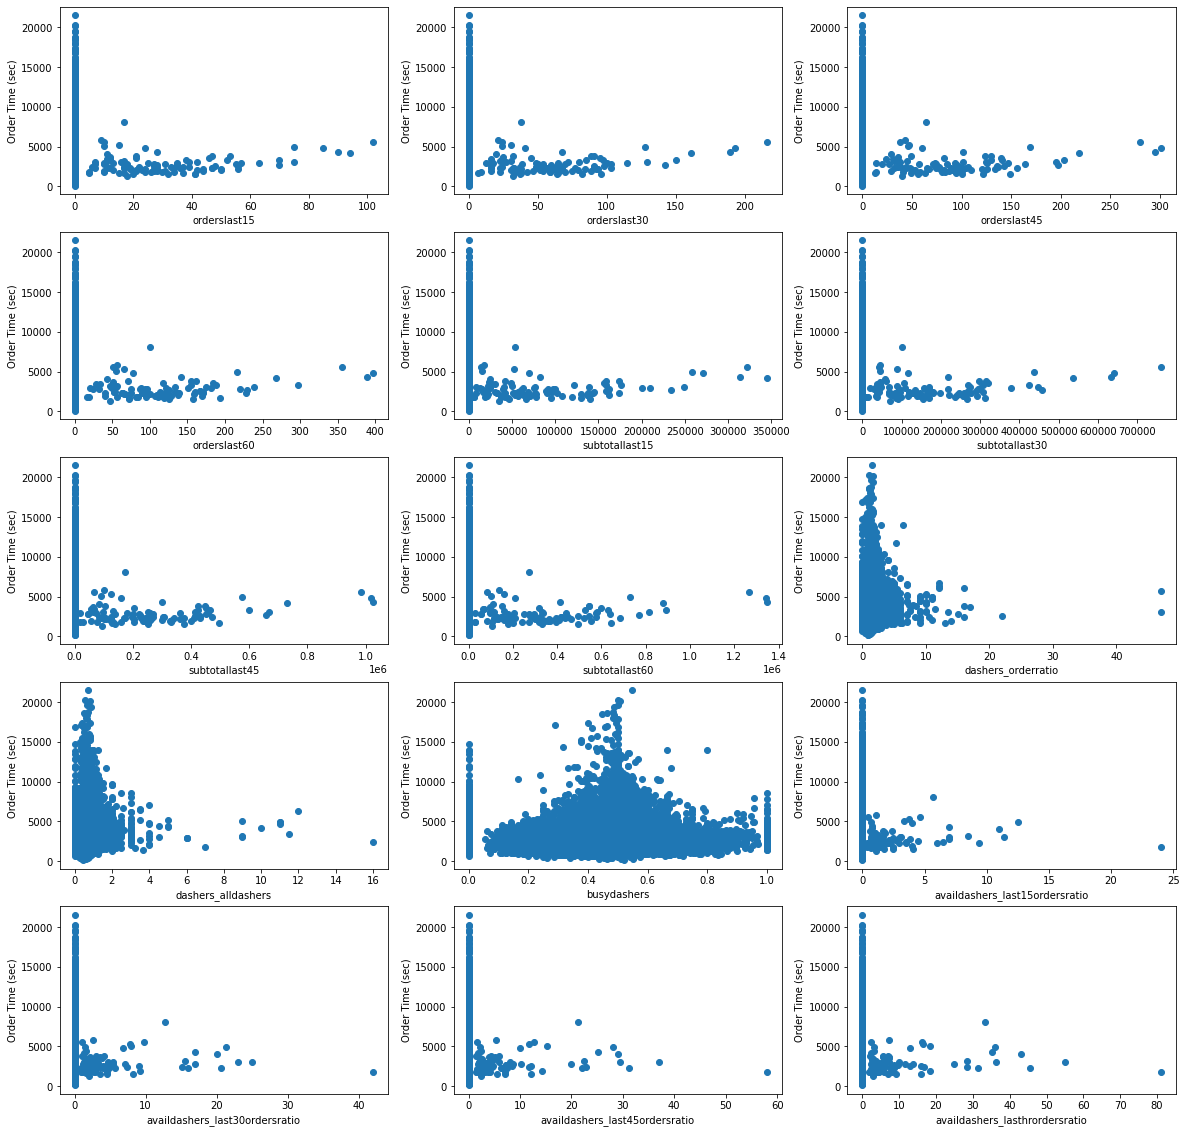

In [28]:
columns = [ #'subtotal','total_onshift_dashers'
             #      ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration',
         "orderslast15","orderslast30","orderslast45","orderslast60",
                                            "subtotallast15", "subtotallast30","subtotallast45","subtotallast60",
'dashers_orderratio','dashers_alldashers','busydashers',
    'availdashers_last15ordersratio','availdashers_last30ordersratio','availdashers_last45ordersratio','availdashers_lasthrordersratio']

fig, axes = plt.subplots(5, 3, figsize=(20, 20))
q=1
for col in (columns):
    plt.subplot(5,3,q)
    plt.scatter(train[col],train['Target'])
    #plt.plot(train[col],train['Target'])
    plt.xlabel(col)
    plt.ylabel('Order Time (sec)')
    q=q+1

Relatively weak associations apart from busydashers, but we'll see if the model picks any of them up. 

### Additional Things to compute:

A few binned and dummy variables to compute:
- hour need to be binned instead of treated as numeric since the difference between 1 and 2am doesn't mean the same as 7 to 8pm 
- also can do this for subtotal
- create dummy variables for categorical variables


The binned variables were binned based on above visualizations, trying to group similar trends together(i.e. peak hours in the morning together)

In [99]:
def Final_Transform(df):
    '''
    Input: 
    df- dataframe, either train or test
    
    Output: dataframe with additional columns
    
    This function will add some columns:
    - binned market_id
    - binned hours based on order frequency(plots above)
    - added categorical variable weekend
    - binned subtotal
    '''
        
    cols=[ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders']

    
    #for j in cols:
        #df[j]=np.log1p(df[j])
        
    
    df['market_id']=df['market_id'].astype("category")
    
    create_hr_bin = ['10pm-1am','2am-7am', '8am','9am-5pm','6pm-9pm', '101pm-1am']
    df['hour_binned'] = pd.cut(df['hour'],[0,1,7,8,17,21,23],labels=create_hr_bin)
    df.loc[df['hour_binned']=='101pm-1am','hour_binned']='10pm-1am'

    create_hr_bin = ['under10','10-30', '30-50', '50more']
    df['subtotalbinned'] = pd.cut(df['hour'],[0,1000,3000,5000,100000000000],labels=create_hr_bin)


    df['weekend']=df['weekend'].astype("category")


    df=pd.get_dummies(df)
    df=df.drop(columns=["hour_binned_101pm-1am"])
    
    return df

train=Final_Transform(train)
test=Final_Transform(test)

In [100]:
train.to_pickle('train.pickle')
test.to_pickle('test.pickle')

# Modeling
I will split by date instead of random so because the test set is a completely different set of date values. This will ensure that the holdout set mimics what my performance will be. 

Also based on model testing, I will remove the upper and lower 2.5%. These represent outliers and will keep delieveries >20 min and <90min. These represent plausible ranges and we want to get these times right. Anything else could be just as attributable to restaurant error or other delivery mishaps.

In [156]:
train = pd.read_pickle('train.pickle')
test = pd.read_pickle('test.pickle')

upper=np.quantile(train['Target'],.975)
lower=np.quantile(train['Target'],.025)

train=train[train['Target']<upper]
train=train[train['Target']>lower]


In [157]:
droppedcols=['index','hour','store_id','created_at','actual_delivery_time','index_col_original']

df_train=train.sort_values('created_at').copy()

df_train=df_train.drop(columns=droppedcols)

df_test=test.sort_values('created_at').copy()


train_set, test_set= np.split(df_train, [int(.8 *len(df_train))])
        
y_train2 = train_set['Target']
y_holdout2 = test_set['Target']

X_train2=train_set.drop(columns=['Target'])
X_holdout2=test_set.drop(columns=['Target'])

#test on smaller subset?
size=.8
X_train, X_test2, y_train, y_test2 = train_test_split(X_train2, y_train2, test_size=size,random_state=109)  
X_holdout, X_test22, y_holdout, y_test22 = train_test_split(X_holdout2, y_holdout2, test_size=size,random_state=109)  


y_train=y_train2
y_holdout=y_holdout2
X_train=X_train2
X_holdout=X_holdout2




# Finding Common columns
commoncols=[*np.intersect1d(X_train.columns, test.columns)]
X_test=df_test[commoncols]

#replicate columns if not in test
i1 = X_train.columns
i2 = X_test.columns
col=i1[~i1.isin(i2)]
for j in col:
    X_test[j]=0
    
X_test=X_test[X_train.columns]

### Standardize Data
This will be helpful for some ML algorithms

In [ ]:
cols=X_train.columns
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_holdout = scale.transform(X_holdout)
X_test = scale.transform(X_test)


X_train=pd.DataFrame(X_train)
X_train.columns=cols
X_holdout=pd.DataFrame(X_holdout)
X_holdout.columns=cols
X_test=pd.DataFrame(X_test)
X_test.columns=cols

### Define Some Error functions
These will return error metrics such as mean absolute error and mean squared error while also fitting a model we input

In [158]:
#performance functions 
def mape(actual, pred): 
    '''
    Input: 
    actual- actual target labels
    pred- predicted target labels
    
    Output: mean absolute percent errors
    
    This function will compute the mape given the actual and predicted values
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def error(actual,forecast,name):
    '''
    Input: 
    actual- actual target labels
    forecast- predicted target labels
    name- name of the series(train, holdout,test)
    
    Output: DF with various error metrics
    
    This function will combine some error metrics into a dataframe given inputs: MAE,MAPE, and RMSE
    '''    
    return pd.DataFrame({'MAE':[mean_absolute_error(actual, forecast).round(2)],'MAPE': [mape(actual,forecast).round(2)],'RMSE': [np.sqrt(mean_squared_error(actual,forecast)).round(2)]},index=pd.Series([name]))

def model_fit(model):
    '''
    Input: 
    model
    
    Output: 
    fit model and printed out error metrics
    
    This function will fit the model on training data, predict on holdout data and print out error metrics based on the above functions.
    '''    
    # Fit it to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the training data X: y_pred
    y_train_pred = model.predict(X_train)

    # Predict and print the label for the new data point X_new
    y_holdout_pred = model.predict(X_holdout)

    print(error(y_train, y_train_pred,'Train'))
    print(error(y_holdout, y_holdout_pred,'Holdout'))
    return model

### Model Fitting
My approach is as follows:
- Fit linear regression
- fit lasso
- fit elastic net
- fit Random Forest
- fit Gradient Boosting

based on the above, we will see which models look promising in terms of error metrics to do further hyperparameter tuning.

In [159]:
# Create Linear Regression
model = LinearRegression()

x=model_fit(model)

          MAE   MAPE    RMSE
Train  600.18  23.04  762.46
            MAE  MAPE    RMSE
Holdout  621.64  22.8  785.93


In [160]:
#lasso regression
model = linear_model.Lasso(alpha=0.1)

model_fit(model)

          MAE   MAPE   RMSE
Train  600.21  23.04  762.5
            MAE  MAPE    RMSE
Holdout  621.58  22.8  785.85


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [161]:
#Elastic Net
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net(parameter from grid search)
model = ElasticNet(l1_ratio=0.89655)

# Setup the GridSearchCV object: gm_cv
#model = GridSearchCV(elastic_net, param_grid, cv=5)
#model.best_params_

model_fit(model)

          MAE   MAPE    RMSE
Train  606.09  23.35  769.52
            MAE   MAPE    RMSE
Holdout  626.64  23.03  792.74


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.89655,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [162]:
# Random Forest
model=RandomForestRegressor(random_state = 0)
model_fit(model)
model

          MAE  MAPE    RMSE
Train  219.98  8.49  281.45
            MAE   MAPE    RMSE
Holdout  620.08  22.74  785.98


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [164]:
#Gradient Boosting
model=GradientBoostingRegressor( verbose=False,random_state=126) 
model=model_fit(model)

model

          MAE   MAPE    RMSE
Train  586.72  22.54  745.48
            MAE   MAPE    RMSE
Holdout  610.83  22.26  775.85


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=126, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=False,
                          warm_start=False)

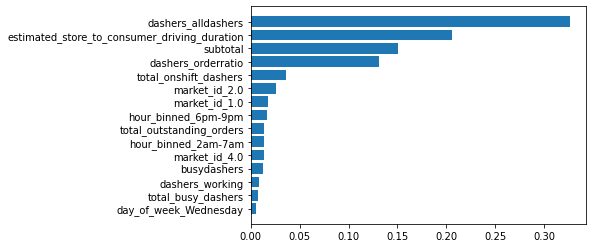

In [165]:
features=15
important=np.argsort(np.abs(model.feature_importances_)).ravel()

plt.barh(range(features), model.feature_importances_.ravel()[important[-features:]])
plt.yticks(range(features), X_train.columns[important[-features:]]);

Random Forest and Gradient Boosting look most promising, so we will tune those

### Random Forest model is overfitting, I will try to change these:
- n_estimators: The more trees, the less likely the algorithm is to overfit. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
- max_features: This defines how many features each tree is randomly assigned. 
- max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk. 
- min_samples_leaf: This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.



In [ ]:
# Let's do Random Forest Grid Search

model_grid=RandomForestRegressor( random_state = 0)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': ['auto','sqrt',4],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,500,1000,2000],
    'max_depth' : [None,4,8,12]
}

model_grid = GridSearchCV(model_grid, param_grid, cv=5)

# Fit it to the training data
model_grid.fit(X_train, y_train)

# Predict the labels for the training data X: y_pred
y_train_pred = model_grid.predict(X_train)

# Predict and print the label for the new data point X_new
y_holdout_pred = model_grid.predict(X_holdout)

print(error(y_train, y_train_pred,'Train'))
print(error(y_holdout, y_holdout_pred,'Holdout'))

### Gradient Boosting model is overfitting, I will try to change these:
- max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk. 
- subsample: percent of dataset to consider at each split
- n_estimators: how big of a tree to grow
- learning rate: slow down the adaptation of the model to the training data.

In [ ]:
# Let's do gradient boosting Grid Search

model_grid=GradientBoostingRegressor( random_state = 0)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1,3,10,20],
     'subsample': [1,.9,.5,.1],
    'n_estimators': [100,500,1000,2000],
    'learning_rate' : [.001,.01,.1,.2]
}

model_grid = GridSearchCV(model_grid, param_grid, cv=5)

# Fit it to the training data
model_grid.fit(X_train, y_train)

# Predict the labels for the training data X: y_pred
y_train_pred = model_grid.predict(X_train)

# Predict and print the label for the new data point X_new
y_holdout_pred = model_grid.predict(X_holdout)

print(error(y_train, y_train_pred,'Train'))
print(error(y_holdout, y_holdout_pred,'Holdout'))

In [166]:
# Random Forest
model=RandomForestRegressor(n_estimators = 1000, 
                                #max_depth=max_depth,
                                max_features='sqrt',random_state = 0)
model_fit(model)
model

          MAE  MAPE    RMSE
Train  214.18  8.24  272.69
            MAE   MAPE    RMSE
Holdout  610.73  22.27  777.38


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [167]:
#Gradient Boosting
model=GradientBoostingRegressor( verbose=False,random_state=126,subsample=.5, n_estimators=1000,learning_rate=.1) 
model=model_fit(model)

model

          MAE   MAPE    RMSE
Train  565.86  21.68  720.44
            MAE   MAPE    RMSE
Holdout  604.76  21.99  769.97


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=126, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=False,
                          warm_start=False)

Overall, we were able to improve the RMSE a little bit. The random forest is still overpredicting, however. Gradient boosting has a slightly better holdout RMSE and it also doesn't severely overfit, leading me to believe it is more stable. For these reasons, I will more forward with gradient boosting.

## Optimize Over/UnderPredicting

One of the big factors of this prediction exercise is the fact that under predicting is far more costly than under prediction. We have so far tried to minimize the total error(smaller errors are much less costly than big errors), but now we will try to shift away from some underpredictions.

One way to do this is to adjust the loss function in gradient boosting. Aside from the regular function, which using mean squared error, the quantile loss penalizes errors based on the quantile and whether the error was positive (actual > predicted) or negative (actual < predicted). This allows the gradient boosting model to optimize not for the mean, but for percentiles. We will see how the positive/negative error combines with the overall rmse. 

In [226]:
# set grid to search over quantiles
alpha=np.linspace(.5,.9,5)

# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls",subsample=.5, n_estimators=1000,learning_rate=.1)
mid_model.fit(X_train, y_train)

#get actual predictions
predictionstrain = pd.DataFrame(y_train)
predictions = pd.DataFrame(y_holdout)

# Predict for base case
predictions['mid'] = mid_model.predict(X_holdout)
predictionstrain['mid'] = mid_model.predict(X_train)

#initial error dictionary 
errortrain={}
errorholdout={}
gr_actualtrain={}
gr_actualholdout={}

#RMSE dictionary
errortrain['mid']=np.sqrt(mean_squared_error(predictionstrain['Target'],predictionstrain['mid'])).round(2)
errorholdout['mid']=np.sqrt(mean_squared_error(predictions['Target'],predictions['mid'])).round(2)

#what % of time prediction is greater than actual
gr_actualtrain['mid']=sum(predictionstrain['mid']>predictionstrain['Target'])/X_train.shape[0]
gr_actualholdout['mid']=sum(predictions['mid']>predictions['Target'])/X_holdout.shape[0]

for alpha in alpha:
    lower_model = GradientBoostingRegressor(loss="quantile",                  
                                        alpha=alpha,subsample=.5, n_estimators=1000,learning_rate=.1)

    # Fit models
    lower_model.fit(X_train, y_train)
    
    #save predictions to dictionaries
    nameforsaving='quantile'+str.split(str(round(alpha*10,0)),'.')[0]
    predictions[nameforsaving] = lower_model.predict(X_holdout)
    predictionstrain[nameforsaving] = lower_model.predict(X_train)
    
    errortrain[nameforsaving]=np.sqrt(mean_squared_error(predictionstrain['Target'],predictionstrain[nameforsaving])).round(2)
    errorholdout[nameforsaving]=np.sqrt(mean_squared_error(predictions['Target'],predictions[nameforsaving])).round(2)
    gr_actualtrain[nameforsaving]=sum(predictionstrain[nameforsaving]>predictionstrain['Target'])/X_train.shape[0]
    gr_actualholdout[nameforsaving]=sum(predictions[nameforsaving]>predictions['Target'])/X_holdout.shape[0]

predictions

,Target,mid,quantile5,quantile6,quantile7,quantile8,quantile9
190176,2664.0,2353.107637,2254.561973,2370.211224,2536.627307,2758.266089,3037.910635
191937,4005.0,3131.780655,2992.675791,3266.538513,3504.224846,3873.797204,4342.855685
101086,1805.0,2563.312666,2499.845200,2649.903981,2706.134151,2977.058027,3252.161127
147839,2213.0,2002.515481,1749.420527,1991.762715,2196.048621,2314.605417,2901.535174
67216,2283.0,2962.233567,2906.910259,3026.626800,3232.477419,3437.880044,3697.708906
...,...,...,...,...,...,...,...
20769,1445.0,2554.639520,2433.587785,2574.666047,2733.857883,3026.252171,3435.584928
176588,2447.0,2358.494572,2136.061597,2384.683798,2560.623450,2938.604549,3508.396890
191661,2092.0,2227.298729,2037.248033,2270.385139,2604.926902,2991.352704,3428.320805
168089,1682.0,2471.363540,2279.280347,2527.307580,2764.034445,3141.735982,3558.856616


In [227]:
errorholdout

{'mid': 770.06,
 'quantile5': 789.89,
 'quantile6': 771.59,
 'quantile7': 811.77,
 'quantile8': 943.75,
 'quantile9': 1244.96}

In [228]:
gr_actualholdout

{'mid': 0.5343963310580204,
 'quantile5': 0.4694165955631399,
 'quantile6': 0.5690326365187713,
 'quantile7': 0.6692886092150171,
 'quantile8': 0.7717576791808873,
 'quantile9': 0.8808127133105802}

From the above, we can see there are large differences between the base scenario(mid) and each different quantile. There is a tradeoff between two things when narrowing down on a model:
- choosing a model with low overall RMSE
- maximizing number of time we are overpredicting rather than under

The mid scenario only overpredicts 53% of the time, while the most aggressive quantile method does it 88% of the time. However, this quantile has a much worse RMSE. I will choose the 70% quantile, as this has a RMSE of 811.77, a mild increase while significantly reducing the number of times we underpredict. Now we only underpredict about 1/3 of the time, a worthwhile tradeoff with the error increase. 

# Fit Final Model

In [229]:
#Gradient Boosting
model=GradientBoostingRegressor( loss="quantile",                  
                                        alpha=.7,subsample=.5, n_estimators=1000,learning_rate=.1) 
model=model_fit(model)

model

          MAE   MAPE    RMSE
Train  642.94  26.77  786.25
            MAE   MAPE   RMSE
Holdout  666.13  26.42  811.5


GradientBoostingRegressor(alpha=0.7, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='quantile',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

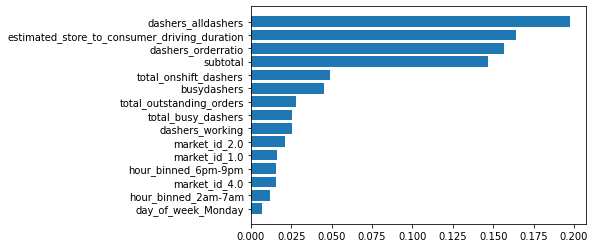

In [233]:
features=15
important=np.argsort(np.abs(model.feature_importances_)).ravel()

plt.barh(range(features), model.feature_importances_.ravel()[important[-features:]])
plt.yticks(range(features), X_train.columns[important[-features:]]);

Some important variables in the model include available dashers ratio, the dashers to order ratio, estimated driving duration, and subtotal. These are mostly features we picked out in EDA that looked promising. Some categorical variables also show up later down the line, such as market ids and hour of the order.

# Predict on Test Set

In [238]:
predicted_duration = model.predict(X_test)
Output=pd.DataFrame({'delivery_id':test.delivery_id,'predicted_duration':predicted_duration})
Output.to_csv('DoorDashPredictions.csv',index=False)
Output

,delivery_id,predicted_duration
0,194096,3005.180089
1,236895,3807.326044
2,190868,3436.369058
3,183076,2829.894316
4,186200,3307.297351
...,...,...
54773,174203,2145.406640
54774,138333,3105.833444
54775,34110,2293.575619
54776,178028,3349.335618


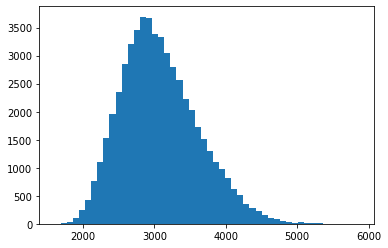

In [232]:
#histogram of test predictions
plt.hist(Output.predicted_duration,bins=50)
plt.show()

# Conclusion
Overall, this was a very interesting dataset to analyze. Although there are many other features that we would love to have, it was possible to get a decent prediction using the available data. To summarize our process was as follows:
- Analyze missing data and impute
- Perform some EDA
- Based on EDA, perform some feature engineering
- Remove extreme values from target variable based on business intuition
- Fit some candidate models
- Perform some hyperparameter tuning
- Predict on Test set

Some of the most important features revolved around dasher availability and order amount. We had to make some tradeoffs with our model, as we were trying to optimize two competing metrics:
- minimizing total error amount
- having more overprediction than underprediction

Overall, we were able to do this via gradient boosting, and underpredict only 33% of the time. Although, this results in slightly higher error rates, I believe this is a worthwhile compromise for the model. In the future, this analysis could be improved by data about restaurant preparation time, number of items ordered, traffic data, and more customer specific information. 